In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rng


import base64
import io
from PIL import Image

In [17]:
def getBw(img):
    im = img
    #gray
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.GaussianBlur(im, (25,25),0)
    #binary
    thresh = 200
    im = cv2.threshold(im, thresh, 255, cv2.THRESH_BINARY)[1]
#     see if need to invert
    n_white_pix = np.sum(im == 255)
    n_black_pix = np.sum(im == 0)
    if n_white_pix > n_black_pix:
        im = cv2.bitwise_not(im)
    return im

def getXYWH(bw):
#     bw = cv2.bitwise_not(bw)
    sum0 = bw.sum(axis = 0)
    sum1 = bw.sum(axis = 1)
    w = len(sum0)
    h = len(sum1)
    x2 , y2, x1, y1= 0, 0, 0,0
    
    while x1 < w and sum0[x1] == 0:
        x1 += 1
    while y1 < h and sum1[y1] == 0:
        y1 += 1
    while x2 < w and sum0[-x2-1] == 0:
        x2 += 1
    while y2 < h and sum1[-y2-1] == 0:
        y2 += 1

    x2 = w - x2
    y2 = h - y2

    return x1, y1, x2, y2


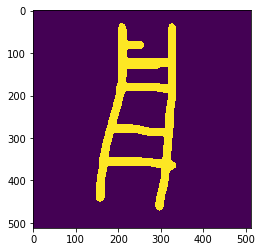

In [18]:
imagePath = "../doodleHistory/ladder.jpg"
img = cv2.imread(imagePath);
bw = getBw(img)
plt.imshow(bw)

True

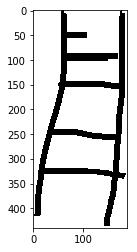

In [21]:
def getRGBAimg(img):
    bw = getBw(img)
    # get a gray version, to process contour
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0) # Remove noise
    ret, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # creat an empty mask, draw contour on it
    mask = np.zeros(img.shape, np.uint8)
    for c in contours:
        acc = 0.03 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, acc, True)
        cv2.fillPoly(mask,[approx], color = (255,255,255))
    # get alpha from mask
    h = img.shape[0]
    w = img.shape[1]
    mb, mg, mr = cv2.split(mask)
    b, g, r = cv2.split(img)
    alpha = np.zeros(b.shape, np.uint8)
    for x in range(0,w):
        for y in range(0,h):
            if mb[x,y] != 255 and bw [x,y] == 0 :
                alpha[x,y] = 0
            else:
                alpha[x,y] = 255
    # merge img with alpha
    rgba = cv2.merge((b,g,r,alpha))
    x1,y1,x2,y2 = getXYWH(bw)
    rgba = rgba[y1:y2, x1:x2]
    rgba = cv2.threshold(rgba, 127, 255, cv2.THRESH_BINARY)[1]
    return rgba

img2 = getRGBAimg(img)
plt.imshow(img2)

cv2.imwrite("test.png", img2)

In [20]:
def stringToRGB(base64_string):
    imgdata = base64.b64decode(str(base64_string))
    image = Image.open(io.BytesIO(imgdata))
    return cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)

def rgbToString(cv2img):
    retval, buffer = cv2.imencode('.png', cv2img)
    imgdata = base64.b64encode(buffer)


#     image = Image.open(io.BytesIO(imgdata))
    return imgdata

data = rgbToString(img2)

print(data)

b'iVBORw0KGgoAAAANSUhEUgAAAL0AAAG4CAYAAAAQbeY3AAAgAElEQVR4AYTBTY9m51X279+51rX3XVXtfnFISAIyT5QJA4sXQZIOERIZIDFEICZ8MwZ8AwaMmCCBnDhOAkgIMQABAsdJSEwctzvdXV11732tdf57i39JVvTIz3Ho6dOnSCIziQhub285SOJgm4NtDsuyMOdk33fmnBwyk2VZyEyur68ZY7AsC2MMDnNO9n1nzklEsK4rmYltIoJlWTjMOTmfz4wxGGNwqCrmnHQ3kri9veV0OnE6nZDEvu9UFYeIYF1XbHOICCKC7vb5fGbbNn7v936Pi4sL/uZv/obM1M3NDRHB9fU1n/nMZ7i+vkYSEUFEIAlJ3MlMJHGwTXdziAgigohAErapKvZ955CZjDEYY1BVzDmpKrqbgyQkIQlJSEISB9t0N91NRJCZRATdTVVRVUhCEhFBZjLG4NDd2CYiyEy2bcM2h+7GNraxzSEiOEhCEpL4uGVZsI1tupvuprvpbmxzeXmJbWxjG9vckcS2bUhCEpKICCQhCUlkJpK4091UFd1Nd/P666/zn//5nzx8+JBlWfwKX/nKV3j99df5y7/8S+7du6c5J/u+U1VIYlkWTqcTy7Iw50QffPABHycJSUhCEndsc8hMDt2NbWxjmzv7vmMbSWQmYwwOVcWcE9tkJuu6EhGcz2fO5zOSWNeVqkISEUFEIImDbQ6n04lt2zifz3Q3kpCEbbqb8/nM5z//eV68eMHFxYUzE0m8+eab3L9/n33fubm54V//9V/56KOP+NznPkdE6NmzZ5zPZy4uLogIJCEJ28w5qSqqimVZkEREIAnbVBVVRXdzOp2wjW0iAkl0N9u2se873U1EMMZgWRbGGByqiqqiu5GEJCRxsI1tDvu+c5CEJCQhCUlIorvJTMYYjDGQRFUx56S7sY0kJHGwTXfT3XQ3kshMMhPbVBXdTUQQEWzbhm0OYwzWdSUz6W66m3